In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
seed = int(time.mktime(dt.datetime.now().timetuple()))
np.random.seed(seed)

In [3]:
arr1 = np.random.rand(20000) * 2 - 1
arr2 = np.random.rand(20000) * 2 - 1

In [4]:
df0 = pd.DataFrame({"A": arr1, "B": arr2})

In [5]:
df0.head(2)

,A,B
0,0.113777,0.439992
1,-0.708774,-0.860889


In [6]:
#生成线性不可分样本
df0["label_nonliner"] = df0.apply(lambda r: np.random.binomial(1, 0.85) if (r["A"] * r["B"]) > 0 else np.random.binomial(1, 0.15), axis=1)
#生成线性可分样本
df0["label_liner"] = df0.apply(lambda r: np.random.binomial(1, 0.85) if r["A"] + r["B"] > 0 else np.random.binomial(1, 0.15), axis=1)
                               
                               

In [7]:
df0.head(5)

,A,B,label_nonliner,label_liner
0,0.113777,0.439992,1,0
1,-0.708774,-0.860889,1,1
2,0.035510,-0.590853,1,0
3,-0.257307,-0.747017,1,1
4,-0.118877,0.424029,0,0


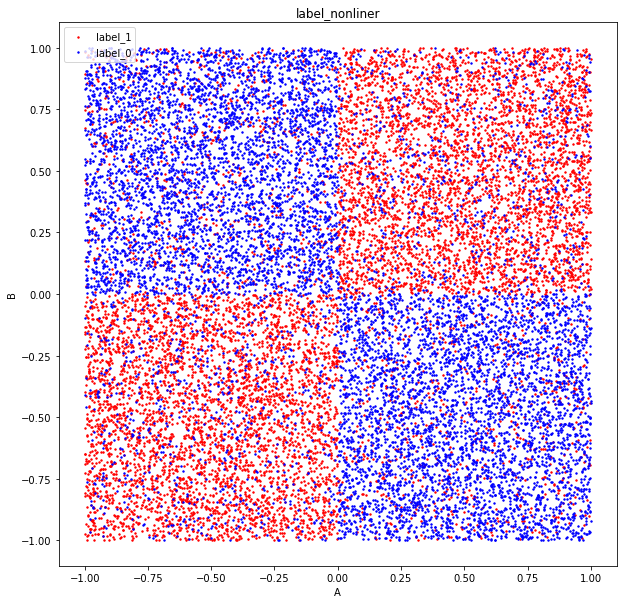

In [8]:
plt.figure(1,figsize=(10,10))
plt.xlabel("A")
plt.ylabel("B")
df_1 = df0.query("label_nonliner==1")
df_0 = df0.query("label_nonliner==0")
plt.scatter(df_1["A"], df_1["B"], label="label_1", c="red", s=2, marker='o')
plt.scatter(df_0["A"], df_0["B"], label="label_0", c="blue", s=2, marker='o')
plt.title("label_nonliner") #设置标题
plt.legend(loc="upper left")
plt.show()

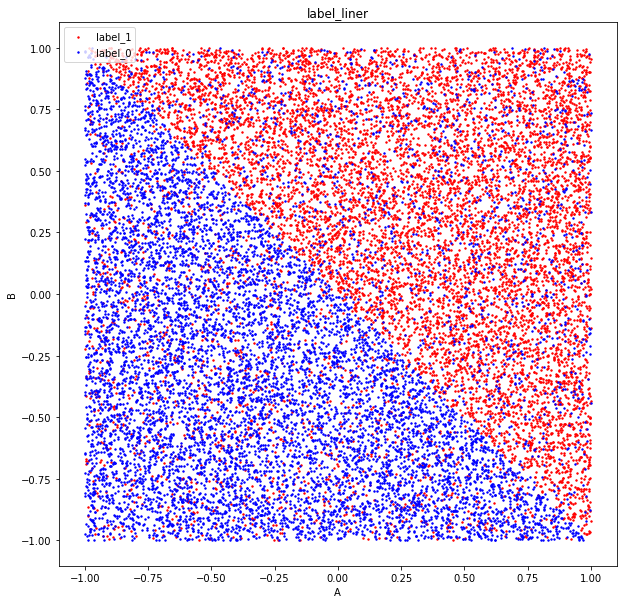

In [9]:
plt.figure(2,figsize=(10,10))
plt.xlabel("A")
plt.ylabel("B")
df_1 = df0.query("label_liner==1")
df_0 = df0.query("label_liner==0")
plt.scatter(df_1["A"], df_1["B"], label="label_1", c="red", s=2, marker='o')
plt.scatter(df_0["A"], df_0["B"], label="label_0", c="blue", s=2, marker='o')
plt.title("label_liner") #设置标题
plt.legend(loc="upper left")
plt.show()

In [10]:
liner_trainx, liner_testx, liner_trainy, liner_testy = train_test_split(df0[["A", "B"]], df0["label_liner"], test_size=0.1)
nonliner_trainx, nonliner_testx, nonliner_trainy, nonliner_testy = train_test_split(df0[["A", "B"]], df0["label_nonliner"], test_size=0.1)


### 线性可分的情况下的LR准确率 
- 大致符合随机数的分布 0.85 

In [11]:
lrmodel = LogisticRegression(random_state=seed)
lrmodel.fit(liner_trainx, liner_trainy)
lrmodel.score(liner_testx, liner_testy)

0.852

### 线性不可分的情况下的LR准确率 
- 基本上是随机数分布的一半 和瞎猜差不多

In [12]:
lrmodel = LogisticRegression(random_state=seed)
lrmodel.fit(nonliner_trainx, nonliner_trainy)
lrmodel.score(nonliner_testx, nonliner_testy)

0.491

In [13]:
dtrain_nonliner = xgb.DMatrix(nonliner_trainx, label=nonliner_trainy)
dtrain_liner = xgb.DMatrix(liner_trainx, label=liner_trainy)
dtest_nonliner = xgb.DMatrix(nonliner_testx, label=nonliner_testy)
dtest_liner = xgb.DMatrix(liner_testx, label=liner_testy)

In [14]:
XGB_params = {
    'max_depth': 4,
    #'num_round': 10000,
    'objective': 'binary:logistic',
    'silent': 0,  # 取0时表示打印出运行时信息，取1时表示以缄默方式运行
    'eval_metric': 'error',  # 校验数据所用评价指标
    'gamma': 0.0,
    # 在树的叶子节点上进一步划分所需的最小损失减少。数值越大，算法越保守。默认0
    'min_child_weight': 1,
    # 在线性回归模型中，这个参数是指建立每个模型所需要的最小样本数。调大这个参数能够控制过拟合，默认1
    # 数的最大深度。缺省值为6
    'lambda': 1,
    # L2正则的惩罚系数，默认0
    #'subsample': 0.9,
    # 用于训练模型的子样本占整个样本集合的比例。防止过拟合。默认1
    #'colsample_bytree': 0.8,
    # 在建立树时对特征采样的比例。缺省值为1
    #'colsample_bylevel': 0.66,
    'eta': 0.05,
    # 通常最后设置eta为0.01~0.2eta通过缩减特征的权重使提升计算过程更加保守。默认0.3
    'tree_method': 'exact',
    'seed': 2011,
    'nthread': 5
    # XGBoost运行时的线程数。缺省值是当前系统可以获得的最大线程数
}
num_round = 10

### xgboost 作为决策树 在线性可分和非线性可分数据上的表现都很好

In [15]:
bst_liner = xgb.train(XGB_params, dtrain_liner, num_round, evals=[(dtrain_liner, "train_liner"), (dtest_liner, "test_liner")])



[0]	train_liner-error:0.180278	test_liner-error:0.1775
[1]	train_liner-error:0.178889	test_liner-error:0.1765
[2]	train_liner-error:0.177278	test_liner-error:0.1745
[3]	train_liner-error:0.178278	test_liner-error:0.1765
[4]	train_liner-error:0.177778	test_liner-error:0.173
[5]	train_liner-error:0.173889	test_liner-error:0.1725
[6]	train_liner-error:0.176056	test_liner-error:0.172
[7]	train_liner-error:0.171111	test_liner-error:0.17
[8]	train_liner-error:0.168444	test_liner-error:0.166
[9]	train_liner-error:0.168944	test_liner-error:0.17


In [16]:
bst_nonliner = xgb.train(XGB_params, dtrain_nonliner, num_round, evals=[(dtrain_nonliner, "dtrain_nonliner"), (dtest_nonliner, "test_nonliner")])


[0]	dtrain_nonliner-error:0.149667	test_nonliner-error:0.153
[1]	dtrain_nonliner-error:0.149667	test_nonliner-error:0.153
[2]	dtrain_nonliner-error:0.149667	test_nonliner-error:0.153
[3]	dtrain_nonliner-error:0.149667	test_nonliner-error:0.153
[4]	dtrain_nonliner-error:0.149667	test_nonliner-error:0.153
[5]	dtrain_nonliner-error:0.149667	test_nonliner-error:0.153
[6]	dtrain_nonliner-error:0.149778	test_nonliner-error:0.153
[7]	dtrain_nonliner-error:0.149778	test_nonliner-error:0.153
[8]	dtrain_nonliner-error:0.149778	test_nonliner-error:0.1525
[9]	dtrain_nonliner-error:0.149778	test_nonliner-error:0.1525
